In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.datasets import ImageFolder

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd
import copy

import torchvision
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Unzipping Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#unpacking zip file
shutil.unpack_archive("/content/drive/MyDrive/lyme.zip", "/content/Datasets/")

Code to balance dataset - do not run this code when testing whole dataset

In [ ]:

#paths to three main folders, each containing Positive and Negative subfolders
main_folders = ['/content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/test', '/content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/train', '/content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/val']

def balance_folders(positive_path, negative_path): #folder balancer
  #get list of files in the 'Positive' and 'Negative' subfolders
    positive_files = os.listdir(positive_path)
    negative_files = os.listdir(negative_path)

    num_positive = len(positive_files)
    num_negative = len(negative_files) #calc number of positives and negatives

    num_to_delete = num_negative - num_positive #figures out how many more negatives therea re

    if num_to_delete > 0:
        files_to_delete = random.sample(negative_files, num_to_delete) #randomly deletes negatives until there are none
        for file in files_to_delete:
            os.remove(os.path.join(negative_path, file))
        return num_to_delete
    return 0

#iterate over each main folder and balance the images
for folder in main_folders:
    positive_path = os.path.join(folder, 'Positive')
    negative_path = os.path.join(folder, 'Negative')

    num_deleted = balance_folders(positive_path, negative_path)
    print(f"Deleted {num_deleted} files from the Negative folder in {folder}.")

print("Balancing complete.")


Deleted 317 files from the Negative folder in /content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/test.
Deleted 2542 files from the Negative folder in /content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/train.
Deleted 318 files from the Negative folder in /content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/val.
Balancing complete.


# Data Visualisation

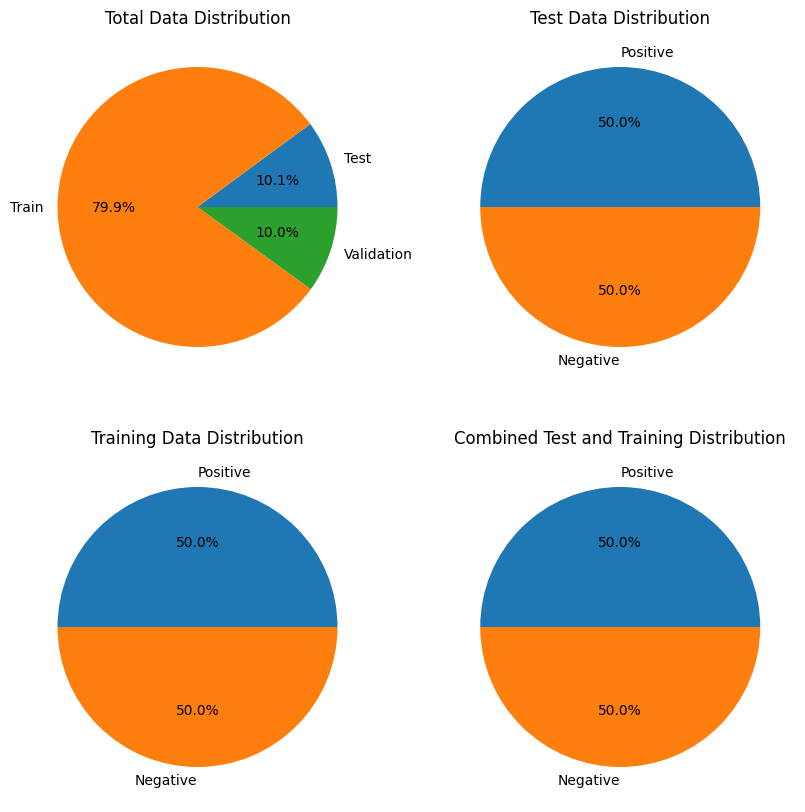

In [ ]:
def count_files(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

def plot_pie_charts(root_dir):
    #counting totals
    test_pos = count_files(os.path.join(root_dir, 'test', 'Positive'))
    test_neg = count_files(os.path.join(root_dir, 'test', 'Negative'))
    train_pos = count_files(os.path.join(root_dir, 'train', 'Positive'))
    train_neg = count_files(os.path.join(root_dir, 'train', 'Negative'))
    val_pos = count_files(os.path.join(root_dir, 'val', 'Positive'))
    val_neg = count_files(os.path.join(root_dir, 'val', 'Negative'))

    #prep for data for pie charts
    test_total = test_pos + test_neg
    train_total = train_pos + train_neg
    val_total = val_pos + val_neg
    total = test_total + train_total + val_total

    # inoput for pie charts
    data_total = [test_total, train_total, val_total]
    labels_total = ['Test', 'Train', 'Validation']

    data_test = [test_pos, test_neg]
    labels_test = ['Positive', 'Negative']

    data_train = [train_pos, train_neg]
    labels_train = ['Positive', 'Negative']

    data_combined = [test_pos + train_pos, test_neg + train_neg]
    labels_combined = ['Positive', 'Negative']

    #plotting
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].pie(data_total, labels=labels_total, autopct='%1.1f%%')
    axs[0, 0].set_title('Total Data Distribution')

    axs[0, 1].pie(data_test, labels=labels_test, autopct='%1.1f%%')
    axs[0, 1].set_title('Test Data Distribution')

    axs[1, 0].pie(data_train, labels=labels_train, autopct='%1.1f%%')
    axs[1, 0].set_title('Training Data Distribution')

    axs[1, 1].pie(data_combined, labels=labels_combined, autopct='%1.1f%%')
    axs[1, 1].set_title('Combined Test and Training Distribution')

    plt.show()

root_dir = '/content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2'
plot_pie_charts(root_dir)


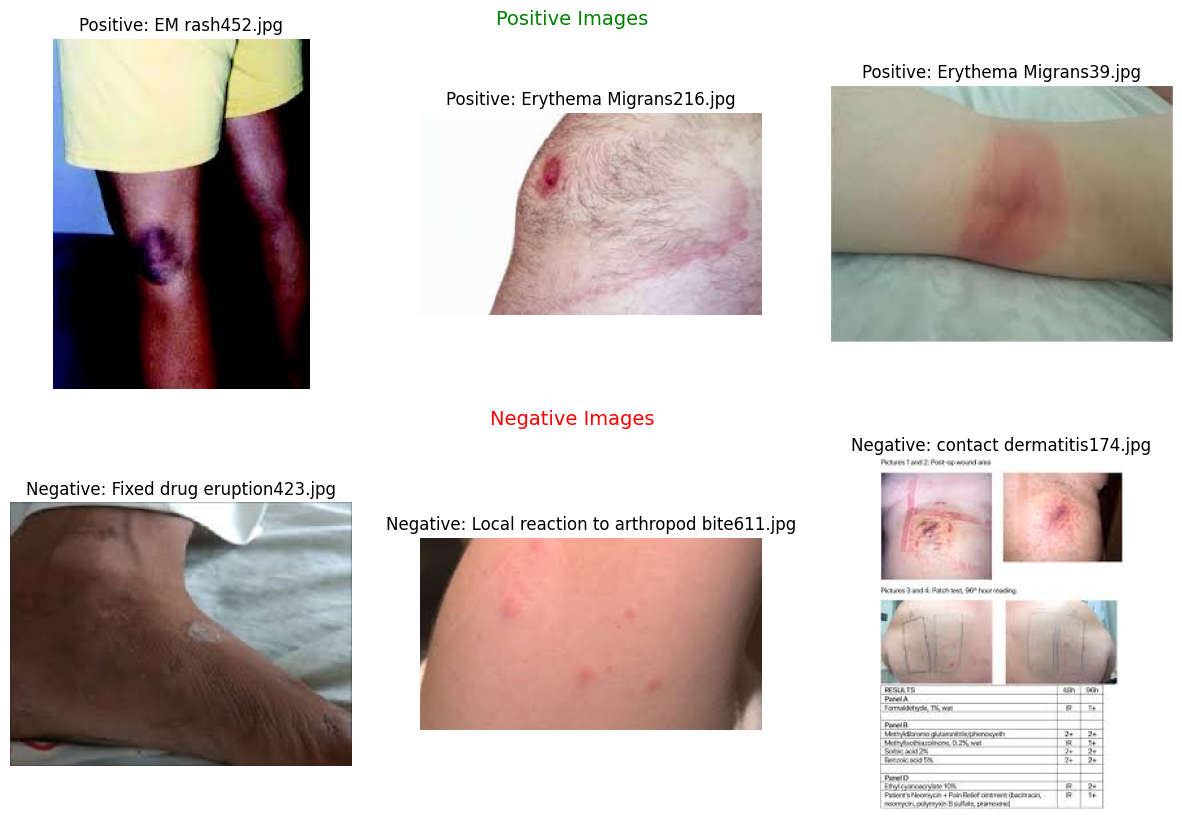

In [ ]:
base_path = "/content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/train"

#paths for positive and negative folders
positive_path = os.path.join(base_path, 'Positive')
negative_path = os.path.join(base_path, 'Negative')

#fun to display images insubplot
def display_random_images(folder_path, label, row):
    # List all files in the folder
    images = os.listdir(folder_path)

    #  select 3 images at random
    selected_images = random.sample(images, 3)

    # show image in subplot
    for i, image_name in enumerate(selected_images):
        plt.subplot(2, 3, row * 3 + i + 1)  # 2 rows, 3 columns, position i+1
        image_path = os.path.join(folder_path, image_name)
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(f"{label}: {image_name}")
        plt.axis('off')  # Turn off axis

#create figure
plt.figure(figsize=(15, 10))

# labels
plt.figtext(0.5, 0.9, "Positive Images", ha="center", va="center", fontsize=14, color="green")

# display pos images
display_random_images(positive_path, 'Positive', 0)

# negative image labels
plt.figtext(0.5, 0.5, "Negative Images", ha="center", va="center", fontsize=14, color="red")

# show neg images
display_random_images(negative_path, 'Negative', 1)

# show plot
plt.show()

# Data Preprosessing

In [ ]:
train_data_for_std = datasets.ImageFolder(root = '/content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/train',
                                  transform = transforms.ToTensor())

normalisation_means = torch.zeros(3)
normalisation_stds = torch.zeros(3) #creates arrays


for img, label in train_data_for_std:
    normalisation_means += torch.mean(img, dim = (1,2))
    normalisation_stds += torch.std(img, dim = (1,2))  #calculates means and standard deviations from training data


normalisation_means /= len(train_data_for_std)
normalisation_stds /= len(train_data_for_std) #returns arrays

print(f'Calculated means: {normalisation_means}')
print(f'Calculated stds: {normalisation_stds}')

Calculated means: tensor([0.6484, 0.5140, 0.4592])
Calculated stds: tensor([0.1987, 0.1851, 0.1826])


In [ ]:
normalize = transforms.Normalize(mean=normalisation_means,
                                 std=normalisation_stds) #uses previous outputs

data_transforms = {
    'train': #aug on training data, not the others
    transforms.Compose([ #normalisation with data augmentation
        transforms.Resize((224,224)), #resize to fit ResNet and MobileNet
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'val': #regular normalisation with the means and standards
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([ #same as val
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = { #define image datasets
    'train':
    datasets.ImageFolder('/content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/train', data_transforms['train']),
    'val':
    datasets.ImageFolder('/content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/val', data_transforms['val']),
    'test':
    datasets.ImageFolder('/content/Datasets/Lyme Full Statified/Lyme Full Statified/DataSplit/image_folder 2/test', data_transforms['test'])

}

dataloaders = { #perform data loading on datasets
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True, #shuffles only training
                                num_workers=0),
    'val':
    torch.utils.data.DataLoader(image_datasets['val'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)
}

select device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #set device
device

device(type='cuda', index=0)

# ResNet50

## loading the model

In [ ]:
model = models.resnet50(pretrained=True).to(device) #downloads model

for param in model.parameters(): #for each parameter, allow it to compute gradient in training
    param.requires_grad = True

model.fc = nn.Sequential(
               nn.Dropout(0.2),  #prevents overfitting
               nn.Linear(2048, 128), #input layer
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device) #2 because binary classification

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Hyperparameters

In [ ]:
criterion = nn.CrossEntropyLoss() #define loss criterion
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) #Learning rate hyperparameter
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) #learning rate decay, patience hyperparameter

## Implementing Model

In [ ]:
def train_model(model, criterion, optimizer, num_epochs, early_stopping_patience = 10):#early stopping
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

            scheduler.step(epoch_loss) #trains the model, keeping track of training and validation loss and accuracys

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) #output losses n accuracys


        if epochs_no_improve == early_stopping_patience: #line for eearly stopping
          print("Early stopping triggered")
          break

    return model, train_losses, train_accs, val_losses, val_accs


In [ ]:
model_trained, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, num_epochs=2) #change epoch number to set max epochs

Epoch 1/2
----------
train loss: 0.6987, acc: 0.5386
val loss: 0.7027, acc: 0.5053
Epoch 2/2
----------
train loss: 0.6776, acc: 0.5785
val loss: 0.6637, acc: 0.6702


## Metrics

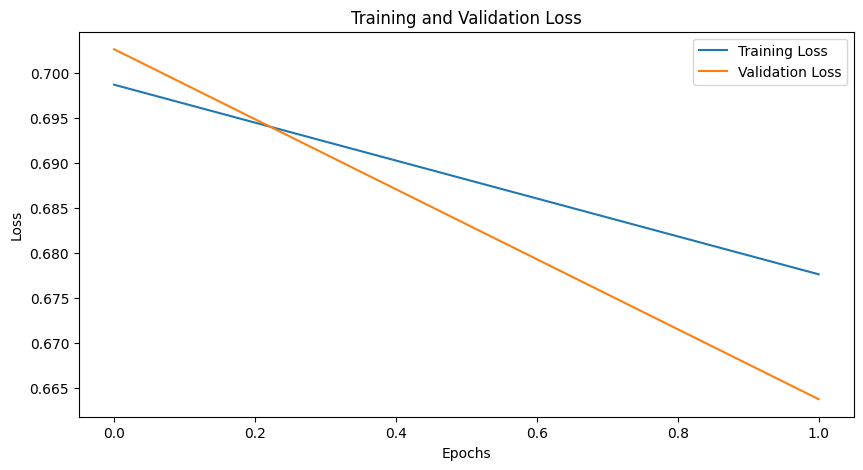

In [ ]:
def plot_losses(train_losses, val_losses):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() #shows training and val loss graphs

# Call the plot_losses function
plot_losses(train_losses, val_losses)

In [ ]:
#sset model to evaluation mode
model.eval()

#initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

probs = torch.zeros(0, dtype=torch.float, device='cpu')
actuals = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        # add prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        # do softmax to get probabilities
        probs_batch = F.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
        probs = torch.cat([probs, probs_batch.cpu()])
        actuals = torch.cat([actuals, labels.cpu()])


Accuracy: 64.2105%


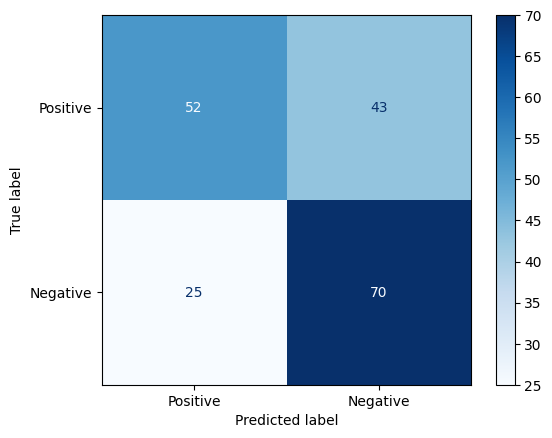

Sensitivity: 0.5474


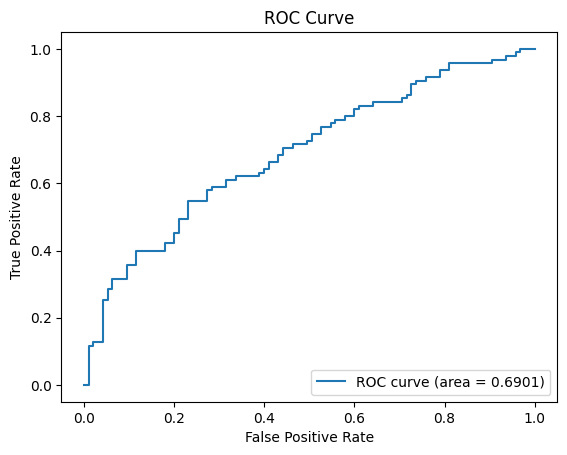

AUC: 0.6901


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

accuracy = accuracy_score(lbllist.numpy(), predlist.numpy())
print(f'Accuracy: {accuracy * 100:.4f}%')

# make confusion matrix
conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy(), labels=[1, 0])

# define class labels
class_names = ['Positive', 'Negative']  # Positive is now first

#display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

TP = conf_mat[0, 0]
FN = conf_mat[0, 1]
sensitivity = TP / (TP + FN)

print(f'Sensitivity: {sensitivity:.4f}')


# plot ROC curve
auc_score = roc_auc_score(actuals.numpy(), probs.numpy())
fpr, tpr, _ = roc_curve(actuals.numpy(), probs.numpy())
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {auc_score:.4f}')


# MobileNetV2

In [ ]:
MobileNetV2 = models.mobilenet_v2(pretrained=True).to(device)

for param in MobileNetV2.parameters():
    param.requires_grad = True

MobileNetV2.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 128), ##all same as ResNet except this, smaller input layer
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
MNV2model_trained, MNV2train_losses, MNV2train_accs, MNV2val_losses, MNV2val_accs = train_model(MobileNetV2, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.7014, acc: 0.4814
val loss: 0.7055, acc: 0.5000
Epoch 2/3
----------
train loss: 0.6991, acc: 0.4987
val loss: 0.7067, acc: 0.4787
Epoch 3/3
----------
train loss: 0.6975, acc: 0.5120
val loss: 0.7049, acc: 0.4947


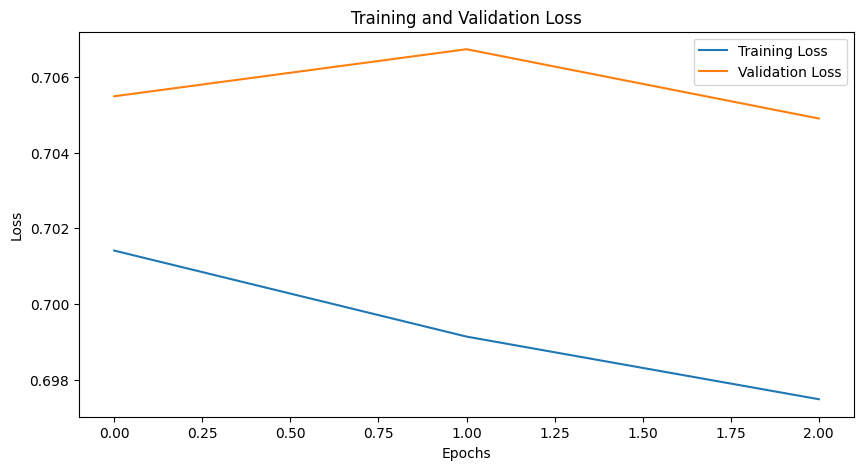

In [ ]:
def plot_losses(train_losses, val_losses):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(MNV2train_losses, label='Training Loss')
    plt.plot(MNV2val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() #shows training and val loss graphs

# show graph
plot_losses(MNV2train_losses, MNV2val_losses)

In [ ]:
#sset model to evaluation mode
MobileNetV2.eval()

#initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

probs = torch.zeros(0, dtype=torch.float, device='cpu')
actuals = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = MobileNetV2(inputs)

        _, preds = torch.max(outputs, 1)

        # add prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

         # do softmax to get probabilities
        probs_batch = F.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
        probs = torch.cat([probs, probs_batch.cpu()])
        actuals = torch.cat([actuals, labels.cpu()])


Accuracy: 47.3684%


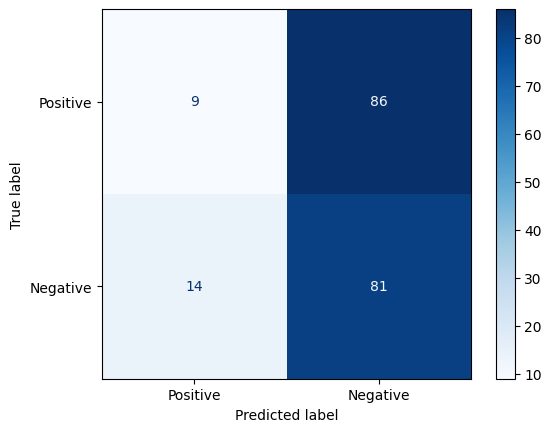

Sensitivity: 0.0947


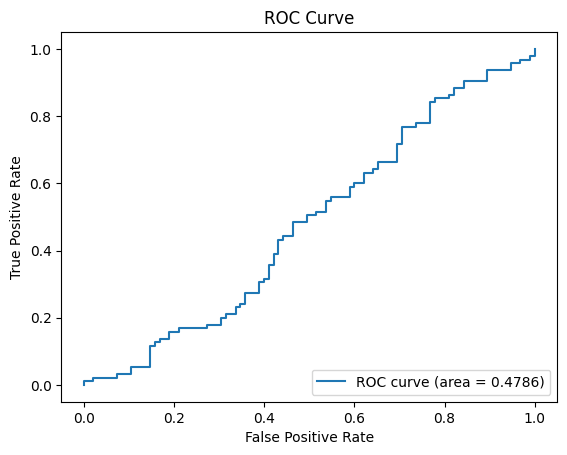

AUC: 0.4786


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

accuracy = accuracy_score(lbllist.numpy(), predlist.numpy())
print(f'Accuracy: {accuracy * 100:.4f}%')

# make confusion matrix
conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy(), labels=[1, 0])

# define class labels
class_names = ['Positive', 'Negative']  # Positive is now first

#display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

TP = conf_mat[0, 0]
FN = conf_mat[0, 1]
sensitivity = TP / (TP + FN)

print(f'Sensitivity: {sensitivity:.4f}')


#plot ROC curve
auc_score = roc_auc_score(actuals.numpy(), probs.numpy())
fpr, tpr, _ = roc_curve(actuals.numpy(), probs.numpy())
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


print(f'AUC: {auc_score:.4f}')
